In [1]:
# import
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from PIL import Image
import shutil

# costants
SEED = 0xDED
KAGGLE = os.path.exists("/kaggle/input")
if KAGGLE:
    print("Detected kaggle environment")

target_w = 256
target_h = 256

batch_size = 8
num_classes = 3    
epochs = 5

learning_rate = 1e-4

Detected kaggle environment


In [2]:
# intialization and common utilities

tf.random.set_seed(SEED)
np.random.seed(SEED)

def fromCwd(path):
    return os.path.join(os.getcwd(), path)


if KAGGLE:
    train_dir = "/kaggle/temp/training"
    valid_dir = "/kaggle/temp/validation"
    data_dir = "/kaggle/input/contadinoset/Development_Dataset/Training"
    temp_dir = "/kaggle/temp/mvdir"
    checkpoint_dir = "/kaggle/temp/checkpoints"
    test_dir = "/kaggle/input/contadinoset/Development_Dataset/Test_Dev"
    output_dir = fromCwd("/kaggle/working")
else:
    train_dir = fromCwd("training")
    valid_dir = fromCwd("validation")
    data_dir = fromCwd("data")
    temp_dir = fromCwd("temp")
    checkpoint_dir = fromCwd("checkpoints")
    test_dir = fromCwd("test")
    output_dir = fromCwd("output")



In [3]:

# move all data to images or mask folders into dest dir
def moveRecursive(source_dir, folders, percent):

    items = os.listdir(source_dir)
    print("Moving from "+ source_dir)

    if not "Images" in items: # normal top folder we should explore all its sub folders
        for fold in items:
            moveRecursive(os.path.join(source_dir, fold), folders, percent)
        return # no more to do in this folder

    # here we got Images in subfolder
    im_dir = os.path.join(source_dir, "Images")
    ms_dir = os.path.join(source_dir, "Masks")
    # read all images and masks
    images = np.sort(os.listdir(im_dir))
    masks = np.sort(os.listdir(ms_dir))

    # make validation
    val_sz = int(len(images) * percent) + 1
    for i in range(val_sz):
        idx = np.random.randint(0, len(images))

        # move both image and mask to validation folder
        os.rename(os.path.join(im_dir, images[idx]), os.path.join(folders[2], images[idx]))
        os.rename(os.path.join(ms_dir, masks[idx]), os.path.join(folders[3], masks[idx]))

        # update refreshed folders without moved elements
        images = np.sort(os.listdir(im_dir))
        masks = np.sort(os.listdir(ms_dir))

    # create train set
    for img in images:
        os.rename(os.path.join(im_dir, img), os.path.join(folders[0], img))
    for msk in masks:
        os.rename(os.path.join(ms_dir, msk), os.path.join(folders[1], msk))

#end    


# move all data from subfolders in source folder to Images/Mask folders in dest folder
def prepareTrainData(source_dir, train_dir, valid_dir, percent = 0.1):

    folders = [] # order: Test_img | Test_mask | valid_img | valid_mask
    for parent in [train_dir, valid_dir]:
        for sub in ["Images", "Masks"]:
            folders.append(os.path.join(parent,sub))

    # check if a folder already exist and skip 
    for f in folders:
        if os.path.exists(f):
            print("[Skipped] Directory already exists: "+ f)
            return folders

    # create folders
    for f in folders:   
        os.makedirs(f)

    moveRecursive(source_dir, folders, percent)
    print("Train and Valid set ready")

    return folders

if not os.path.exists(temp_dir):
    shutil.copytree(data_dir, temp_dir) # required to copy everythin because preparaTrainData move images

folders = prepareTrainData(temp_dir, train_dir, valid_dir)

Moving from /kaggle/temp/mvdir
Moving from /kaggle/temp/mvdir/Pead
Moving from /kaggle/temp/mvdir/Pead/Haricot
Moving from /kaggle/temp/mvdir/Pead/Mais
Moving from /kaggle/temp/mvdir/Weedelec
Moving from /kaggle/temp/mvdir/Weedelec/Haricot
Moving from /kaggle/temp/mvdir/Weedelec/Mais
Moving from /kaggle/temp/mvdir/Roseau
Moving from /kaggle/temp/mvdir/Roseau/Haricot
Moving from /kaggle/temp/mvdir/Roseau/Mais
Moving from /kaggle/temp/mvdir/Bipbip
Moving from /kaggle/temp/mvdir/Bipbip/Haricot
Moving from /kaggle/temp/mvdir/Bipbip/Mais
Train and Valid set ready


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create generators
rot_range = 45
h_shift = 10
w_shift = 10
h_flip = True
w_flip = True
zoom = 0.3

img_data_gen = ImageDataGenerator(
    rotation_range=rot_range,
    width_shift_range=w_shift,
    height_shift_range=h_shift,
    zoom_range=zoom,
    horizontal_flip=h_flip,
    vertical_flip=w_flip,
    fill_mode='reflect'
    )

mask_data_gen = ImageDataGenerator(
    rotation_range=rot_range,
    width_shift_range=w_shift,
    height_shift_range=h_shift,
    zoom_range=zoom,
    horizontal_flip=h_flip,
    vertical_flip=w_flip,
    fill_mode='reflect'
    )


In [5]:
  #convert a mask in rgb to actual classes
  def rgb_to_class(mask_arr):

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [6]:
#create custom generator

class CustomGenerator(tf.keras.utils.Sequence):

  def __init__(self, directory, img_generator=None, mask_generator=None, preprocessing_function=None, out_shape=[256, 256]):
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.im_path = os.path.join(directory, "Images")
    self.ms_path = os.path.join(directory, "Masks")
    self.images = np.sort(os.listdir(self.im_path))
    self.masks = np.sort(os.listdir(self.ms_path))


  def __len__(self):
    return len(self.images)


  def __getitem__(self, index):
    # Read Image
    img = Image.open(os.path.join(self.im_path, self.images[index]))
    mask = Image.open(os.path.join(self.ms_path, self.masks[index]))
    
    if os.path.splitext(self.images[index])[0] != os.path.splitext(self.masks[index])[0]:
        print("Image-Mask mismatch for: " +self.images[index]+" -> "+ self.masks[index])
        
    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img) / 255.
    mask_arr = np.array(mask)

    out_mask = []

    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    out_mask = rgb_to_class(np.float32(out_mask))
    out_mask = np.expand_dims(out_mask, -1)


    return img_arr, out_mask

In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

train = CustomGenerator(train_dir,
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        out_shape=[target_w, target_h],
                        #preprocessing_function=preprocess_input
                        )

valid = CustomGenerator(valid_dir,
                        out_shape=[target_w, target_h], 
                        #preprocessing_function=preprocess_input
                       )

print("Train dataset size: "+ str(len(train)))
print("Validation dataset size: " + str(len(valid)))


Train dataset size: 640
Validation dataset size: 80


In [8]:

out_pt = (tf.float32, tf.float32)
out_shp = ([target_h, target_w, 3], [target_h, target_w, 1])

train_dataset = tf.data.Dataset.from_generator(lambda: train, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat().cache()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat().cache()

print(train_dataset)


<CacheDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [9]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

iterator = iter(train_dataset)


[0. 1. 2.]


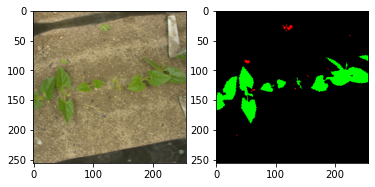

<Figure size 1800x576 with 0 Axes>

[0. 1. 2.]


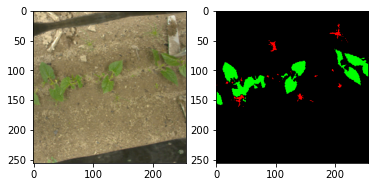

<Figure size 1800x576 with 0 Axes>

In [10]:
for k in range(2):
  # plot
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(18, 5, forward=True)
  

  augmented_img, target = next(iterator)
  augmented_img = augmented_img[0]   # First element
  augmented_img = augmented_img * 255  # denormalize


  target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

  print(np.unique(target))

  target_img = np.zeros([target.shape[0], target.shape[1], 3])

  target_img[np.where(target == 0)] = [0, 0, 0]
  target_img[np.where(target == 1)] = [0, 255, 0] 
  target_img[np.where(target == 2)] = [255, 0, 0] 

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()

In [28]:
# Model

depth=5
start_f=256

model = tf.keras.Sequential()
    
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(target_h, target_w, 3))

for layer in vgg.layers:
    layer.trainable = False
    

model.add(vgg)

for i in range(depth):
    model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same'))
    model.add(tf.keras.layers.ReLU())

    start_f = start_f // 2


model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    

# Visualize created model as a table
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       1179904   
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_6 (ReLU)               (None, 32, 32, 128)      

In [29]:
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# compole model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[meanIoU] 
    )

In [30]:
from datetime import datetime

now = datetime.now().strftime('%b%d_%H-%M-%S')

#checkpoint_dir = checkpoint_dir+str(now)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

# setup callbacks
# -----------------------

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'cp_{epoch:02d}.ckpt'), save_best_only=True, monitor='val_meanIoU'),
    tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=5)
]


In [31]:
history = model.fit(
          x=train_dataset,
          epochs=epochs,
          steps_per_epoch=len(train)/batch_size,
          validation_data=valid_dataset,
          validation_steps=len(valid)/batch_size,
          callbacks=callbacks
          )

Epoch 1/5
80/80 [==============================] - 309s 4s/step - loss: 0.4159 - meanIoU: 0.0020 - val_loss: 0.4119 - val_meanIoU: 6.1125e-12
Epoch 2/5
13/80 [===>..........................] - ETA: 1:46 - loss: 0.3878 - meanIoU: 1.1679e-11

KeyboardInterrupt: 

In [ ]:
# plot alla metrics 
idx = 1
mtr = ['loss','meanIoU']

plt.figure(figsize=(25, 8))

for m in mtr:
    x = history.history[m]
    val_x = history.history['val_' + m]

    plt.subplot(1, len(mtr), idx)
    plt.plot(x, label='Training ' + m)
    plt.plot(val_x, label='Validation ' + m)
    plt.legend(loc='lower right')
    plt.title('Training and Validation ' + m)
    idx += 1

plt.show()

In [ ]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# return {rle crop prediction, rle weed prediction} img shape
def make_prediction(model, image):

    print("Original size: "+ str(image.size))

    img = image.resize([target_w, target_h]) # resize to the network expected size and keep a copy of the original img
    img = np.array(img) / 255. # rescale
    img = tf.expand_dims(img, 0) # add "batch" dimension

    out = model(img, training=False) # predict

    out= tf.squeeze(out, 0) # remove batch dimension to get a 3d vector
    # we got a 3d vector with 3 deph and we need to rescale it to original input size
    # so we denormalize if (output of softmax is 0 < val < 1)
    # and we treat it as img to resize in plt
    out = Image.fromarray(np.uint8(out * 255.)).resize(image.size)
    out = np.array(out)
    # rescale and resize should preserve the old max channels
    # so we can ignore the rescaling to 0-1 again
    out = tf.math.argmax(out, axis=-1) 

    print("Predictions:" + str(out.shape))

    return out, image.size

# create function to evaluate the model and output results in requeisted format
def output_predictions(model, test_dir):
    submission_dict = {}
    #print(test_dir)

    # iterate all datasets keeping name
    for team in os.listdir(test_dir): #team == dataset name
        team_dir = os.path.join(test_dir, team)

        # iterate all corps for a dataset keeping name
        for crop in os.listdir(team_dir):
            crop_dict = {}
            img_dir = os.path.join(team_dir, crop)
            img_dir = os.path.join(img_dir, "Images")
            # iterate all images 
            for fl in os.listdir(img_dir):
                #print("img: "+ fl)
                # get prediction from model
                image = Image.open(os.path.join(img_dir, fl))
                prediction, shape = make_prediction(model, image)

                filename, file_extension = os.path.splitext(fl)
                # prepare output dict
                submission_dict[filename] = {
                    'shape': shape,
                    'team': team,
                    'crop': crop,
                    'segmentation': {'crop': rle_encode(prediction == 1), 'weed':rle_encode(prediction == 2)}
                }
            # end for fl
        # end for crop
    #end for team

    return submission_dict
    


In [ ]:
# plot result of a validation image to understand if net is learning right


iterator = iter(train_dataset)
img, mask = next(iterator)




fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 5, forward=True)

img = img[0] * 255
i = Image.fromarray(np.uint8(img))
out, shape = make_prediction(model, i)

# expected mask
target = np.array(mask[0, ..., 0])   # First element (squeezing channel dimension)

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [0, 255, 0] 
target_img[np.where(target == 2)] = [255, 0, 0] 

#prediction
out_img = np.zeros([out.shape[0], out.shape[1], 3])

out_img[np.where(out == 0)] = [0, 0, 0]
out_img[np.where(out == 1)] = [0, 255, 0] 
out_img[np.where(out == 2)] = [255, 0, 0] 

ax[0].imshow(np.uint8(img))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(out_img))

plt.show()


In [ ]:
import json

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# output last model
print("Making prediction with latest model...")
loss, metrics = model.evaluate(valid_dataset, verbose=2, steps=len(valid))

iou = "{:5.2f}".format(100 * metrics)
loss = "{:5.2f}".format(loss)

print("Last model expected results: loss:{}, iou: {}%".format(loss, iou))
res = output_predictions(model, test_dir)

name = '0latest_iou' + iou + '_loss' + loss +'.json'
with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

print("Done")

In [ ]:
import json

# predict with checkpoint models
print("Making prediction with best models, this may take a while...")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num = 0
ckps = os.listdir(checkpoint_dir)
for cp in ckps:
    model.load_weights(os.path.join(checkpoint_dir, cp))

    loss, metrics = model.evaluate(valid_dataset, verbose=2, steps=len(valid))

    #acc = "{:5.2f}".format(100 * metrics)
    iou = "{:5.2f}".format(100 * metrics)
    loss = "{:5.2f}".format(loss)

    print("Model expected results: loss:{}, iou: {}%".format(loss, acc, iou))
    res = output_predictions(model, test_dir, use_crop)

    # write to file
   
    name = 'iou' + iou + '_loss' + loss +'.json'
    with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

    num += 1
    print("Progress: "str(num)+"/"+str(len(ckps)))

print("Done")